In [1]:
%matplotlib inline
import numpy
import numpy as np
from matplotlib import pyplot as plt
from amuse.units import (units, constants)
from amuse.ext.orbital_elements import new_binary_from_orbital_elements
from amuse.ext.orbital_elements import orbital_elements_from_binary
from amuse.ext.protodisk import ProtoPlanetaryDisk
from amuse.ext.composition_methods import *
from amuse.lab import Particles
from amuse.lab import nbody_system
from amuse.lab import new_powerlaw_mass_distribution
from amuse.plot import scatter
from amuse.community.ph4.interface import ph4
from amuse.community.fi.interface import Fi
from amuse.couple import bridge
# from amuse.community.huayno.interface import Huayno

In [2]:
def orbital_period(Mtot, a):
    return (((4 * numpy.pi**2) * a**3)/(constants.G * Mtot)).sqrt()

# def relative_orbital_velocity(distance, mass=SMBH.mass):
#     return (constants.G*mass/distance).sqrt()

def plot():
    plt.figure(figsize=(8,6))
    scatter(BHdisk.x.value_in(units.pc), BHdisk.y.value_in(units.pc), s=10, alpha=0.8, c='blue', label='BH')
    scatter(SMBH.x.value_in(units.pc), SMBH.y.value_in(units.pc), s=50, c='r', label='SMBH')
    plt.annotate(str(round(model_time.value_in(units.Myr)))+" Myr", xy=(6.9, 9), xytext=(6.9, 9), 
                 weight='heavy', bbox=dict(boxstyle='round,pad=0.5', fc='yellow', ec='k', lw=1, alpha=0.5))
    #plt.title("Evolved to t = "+str(round(model_time.value_in(units.Myr)))+" Myr")
    plt.axis('square')
    plt.xlim([-r, r])
    plt.ylim([-r, r])
    

# Distance to (0,0)
def dist(body):
    return (body.x**2+body.y**2+body.z**2).sqrt()

# Define collision detection
def merge_two_stars(bodies, particles_in_encounter):
    com_pos = particles_in_encounter.center_of_mass()
    com_vel = particles_in_encounter.center_of_mass_velocity()
    d = (particles_in_encounter[0].position - particles_in_encounter[1].position)
    v = (particles_in_encounter[0].velocity - particles_in_encounter[1].velocity)
    print("Two BHs", particles_in_encounter.name, particles_in_encounter.mass.in_(units.MSun),
          "collided with d=", d.length().in_(units.au))
    
    particles_in_encounter[np.argmax(particles_in_encounter.mass)].mass = particles_in_encounter.total_mass()
    particles_in_encounter[np.argmax(particles_in_encounter.mass)].position = com_pos
    particles_in_encounter[np.argmax(particles_in_encounter.mass)].velocity = com_vel
    particles_in_encounter[np.argmax(particles_in_encounter.mass)].radius = particles_in_encounter.radius.sum()
    bodies.remove_particle(particles_in_encounter[np.argmin(particles_in_encounter.mass)])
    
#     new_particle=Particles(1)
#     new_particle.mass = particles_in_encounter.total_mass()
#     new_particle.name = particles_in_encounter[np.argmax(particles_in_encounter.mass)].name
#     new_particle.position = com_pos
#     new_particle.velocity = com_vel
#     new_particle.radius = particles_in_encounter.radius.sum()
#     bodies.add_particles(new_particle)
#     bodies.remove_particles(particles_in_encounter)
    
def resolve_collision(collision_detection, gravity, bodies):
    if collision_detection.is_set():
        print("Well, we have an actual collision between two or more BHs.")
        print("This happened at time=", gravity.model_time.in_(units.Myr))
        for ci in range(len(collision_detection.particles(0))): 
            encountering_particles = Particles(particles=[collision_detection.particles(0)[ci],
                                                          collision_detection.particles(1)[ci]])
            colliding_BHs = encountering_particles.get_intersecting_subset_in(bodies)
            merge_two_stars(bodies, colliding_BHs)
            bodies.synchronize_to(gravity.particles)

            
            
# Binaries detection
def get_binaries(particles,hardness=0.5,G=constants.G):
    n=len(particles)
    total_Ek=(0.5*particles.mass*(particles.vx**2+particles.vy**2+particles.vz**2)).sum()
    average_Ek=total_Ek/particles.mass.sum()
    max_mass=particles.mass.amax()
    limitE=hardness*average_Ek
    
    a=numpy.argsort(particles.x.number)
    a=np.delete(a,particles[a].name=="SMBH")
    n=len(a)

    binaries=[]

    for i in range(0, n-1):
        j=i+1
        while j<n and j<i+10 and (particles.x[a[j]]-particles.x[a[i]])<2*G*max_mass/limitE:
            r2=(particles.x[a[j]]-particles.x[a[i]])**2+ \
               (particles.y[a[j]]-particles.y[a[i]])**2+ \
               (particles.z[a[j]]-particles.z[a[i]])**2 
            v2=(particles.vx[a[j]]-particles.vx[a[i]])**2+ \
               (particles.vy[a[j]]-particles.vy[a[i]])**2+ \
               (particles.vz[a[j]]-particles.vz[a[i]])**2 
            r=r2**0.5
            eb=G*(particles.mass[a[i]]+particles.mass[a[j]])/r-0.5*v2
            if eb > limitE:
                binary=particles[[a[i],a[j]]].copy()
                binary.hardness=eb/average_Ek
                com_pos = binary.center_of_mass()
                binary_momentum = binary.velocity * binary.mass.reshape((-1,1))
                L_b = (binary.position-com_pos).cross(binary_momentum).sum(axis=0)
                L_b = L_b.in_(units.pc*units.MSun*units.km/units.s)
                binary.thetaz = L_b[2] / L_b.length() # angle between the angular momentum and z-axis
                binaries.append(binary)
            j+=1  

    return binaries, average_Ek

## Initial condition

In [16]:
# Start with Sgr A*
SMBH = Particles(1) 
SMBH.name = "SMBH"
SMBH.mass = 4.154e+6 | units.MSun
SMBH.position = (0, 0, 0) | units.pc
SMBH.velocity = (0, 0, 0) | units.kms
SMBH.radius = 2*constants.G*SMBH.mass/constants.c**2

n_BHs = 300 # Number of stellar-mass BHs
r = 10 # (parsec) The outmost orbital radius of BHs surrounding the SMBH
model_time = 0 | units.Myr

# Make BH disk
def make_BHdisk_around_SMBH(SMBH, n_BHs=n_BHs):
    R = r|units.pc
    Ndisk = n_BHs
    Rin = 0.1
    Rout = 1
    Pinner1 = orbital_period(SMBH.mass, Rin*R)
    converter1 = nbody_system.nbody_to_si(SMBH.mass.sum(), R)
    masses = new_powerlaw_mass_distribution(Ndisk, 1.0|units.MSun, 100.0|units.MSun, 2.35) # BH masses in powerlaw
    BHdisk = ProtoPlanetaryDisk(Ndisk,
                              convert_nbody=converter1,
                              Rmin=Rin,
                              Rmax=Rout,
                              q_out=10.0,
                              discfraction=masses.sum()/SMBH.mass).result
    BHdisk.mass = masses
    BHdisk.name = np.arange(1,n_BHs+1).astype("str")
    BHdisk.radius = 2*constants.G*BHdisk.mass/constants.c**2
    BHdisk.remove_attribute_from_store('u')
#     BHdisk.move_to_center()
    return BHdisk, Pinner1, converter1

# Make gas disk
def make_gasdisk_around_SMBH(SMBH=SMBH, Mdisk=1e-3, rho=3.0, Ndisk=1000):
    R = r|units.pc
    Ndisk = Ndisk
    Rin = 0.1
    Rout = 1
    Pinner2 = orbital_period(SMBH.mass, Rin*R)
    Mdisk = Mdisk * SMBH.mass
    converter2 = nbody_system.nbody_to_si(SMBH.mass.sum(), R)
    
    gasdisk = ProtoPlanetaryDisk(Ndisk,
                              convert_nbody=converter2,
                              Rmin=Rin,
                              Rmax=Rout,
                              q_out=10.0,
                              discfraction=Mdisk/SMBH.mass).result
    gasdisk.name = "gas disk"
#     gasdisk.move_to_center()
    masses = Mdisk/float(Ndisk)
    gasdisk.mass = masses
    rho = rho | (units.g/units.cm**3)
    gasdisk.radius = (gasdisk.mass/(4*rho))**(1./3.)
    return gasdisk, Pinner2, converter2

gasdisk, Pinner2, converter2 = make_gasdisk_around_SMBH(SMBH)
BHdisk, Pinner1, converter1 = make_BHdisk_around_SMBH(SMBH)

# Name each BH
for i in range(n_BHs):
    BHdisk[i].name = "BH"+BHdisk[i].name
    
# Backup
SMBH0, BHdisk0, gasdisk0 = SMBH.copy(), BHdisk.copy(), gasdisk.copy()

BH_init = np.loadtxt("BH_init.txt", dtype='str',delimiter=',')
for i in range(len(BHdisk0)):
    BHdisk0.mass[i] = float(BH_init[i,0]) | units.MSun
    BHdisk0.name[i] = BH_init[i,1]
    BHdisk0.radius[i] = float(BH_init[i,2]) | units.m
    BHdisk0.vx[i] = float(BH_init[i,3]) | units.kms
    BHdisk0.vy[i] = float(BH_init[i,4]) | units.kms
    BHdisk0.vz[i] = float(BH_init[i,5]) | units.kms
    BHdisk0.x[i] = float(BH_init[i,6]) | units.pc
    BHdisk0.y[i] = float(BH_init[i,7]) | units.pc
    BHdisk0.z[i] = float(BH_init[i,8]) | units.pc
    
BHdisk = BHdisk0.copy()

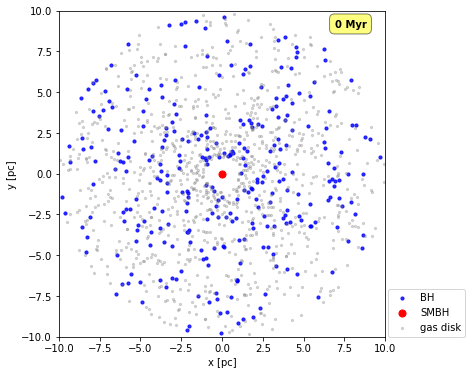

In [10]:
# The initial distribution of our objects
plot()
scatter(gasdisk.x.value_in(units.pc), gasdisk.y.value_in(units.pc), s=5, alpha=0.3, c='gray', label="gas disk")
plt.xlabel("x [pc]")
plt.ylabel("y [pc]")
plt.legend(bbox_to_anchor=(1.01, 0), loc=3, borderaxespad=0)
plt.show()

## Bridge Nbody with gas disk

In [29]:
import os,sys

def ProgressBar(total, progress):
    barLength, status = 20, ""
    progress = float(progress) / float(total)
    if progress >= 1.:
        progress, status = 1, "\r\n"
    block = int(round(barLength * progress))
    text = "\r[{}] {:.0f}% {}".format(
        "#" * block + "-" * (barLength - block), round(progress * 100, 0),
        status)
    sys.stdout.write(text)
    sys.stdout.flush()

In [86]:
def gravhydro(Mdisk=1e-3, rho=3.0, Ndisk=1000):
    
    print("Running(Mdisk="+str(Mdisk)+",rho="+str(rho)+",Ndisk="+str(Ndisk)+")......")
    
    bodies = Particles(0)
    bodies.add_particles(SMBH0)
    bodies.add_particles(BHdisk0)
    
    gasdisk, Pinner2, converter2 = make_gasdisk_around_SMBH(SMBH0, Mdisk=Mdisk, rho=rho, Ndisk=Ndisk)

    SMBH = bodies[bodies.name=="SMBH"]
    BHdisk = bodies[bodies.name!="SMBH"]

    Nbody = SMBH+BHdisk

    gravityA = ph4(converter2, number_of_workers=32)
    gravityA.particles.add_particles(Nbody)
    channel = {"from_BHs": bodies.new_channel_to(gravityA.particles),
                "to_BHs": gravityA.particles.new_channel_to(bodies)}

    hydro = Fi(converter2, mode="openmp", workers=32)
    hydro.parameters.use_hydro_flag = True
    hydro.parameters.radiation_flag = False
    hydro.parameters.gamma = 1
    hydro.parameters.isothermal_flag = True
    hydro.parameters.integrate_entropy_flag = False
    hydro.parameters.timestep = 5e2 | units.yr
    hydro.parameters.verbosity = 0
    hydro.parameters.eps_is_h_flag = False    # h_smooth is constant
    eps = 10 | units.au
    hydro.parameters.gas_epsilon = eps
    hydro.parameters.sph_h_const = eps
    
    bodies.add_particles(gasdisk)
    gasdisk = bodies[bodies.name=="gas disk"]

    hydro.particles.add_particles(gasdisk)
    # hydro.dm_particles.add_particles(SMBH.as_set())
    channel.update({"from_gasdisk": gasdisk.new_channel_to(hydro.particles)})
    channel.update({"to_gasdisk": hydro.particles.new_channel_to(gasdisk)})
    # channel.update({"from_smbh": SMBH.new_channel_to(hydro.dm_particles)})
    # channel.update({"to_smbh": hydro.dm_particles.new_channel_to(SMBH)})

    fig_root = "figure_disk/"
    fig_root1 = fig_root+"Mdisk="+str(Mdisk)+"_rho="+str(rho)+"_Ndisk="+str(Ndisk)+"/"
    
    if os.path.exists(fig_root1)==False:
        os.mkdir(fig_root1)
    
    # Bridge gravity and hydro
    gravhydro = bridge.Bridge(use_threading=False) #, method=SPLIT_4TH_S_M4)
    gravhydro.add_system(gravityA, (hydro,))
    gravhydro.add_system(hydro, (gravityA,))

    # Stopping condition of collision 
    stopping_condition = gravityA.stopping_conditions.collision_detection
    stopping_condition.enable()
    collision_radius_multiplication_factor = 1e5

    Nbody.radius *= collision_radius_multiplication_factor

    # Bridge timestep
    gravhydro.timestep = 5e3 | units.yr

    binary_b = []

    model_time = 0 | units.Myr
    end_time = 6 | units.Myr
    time = [] | units.Myr
    dt = 1 | units.Myr
    x = 0

    gravity_initial_total_energy = gravityA.get_total_energy() + hydro.get_total_energy()

    while model_time < end_time:    

        gravhydro.evolve_model(model_time)
        resolve_collision(stopping_condition, gravityA, Nbody) # Collision detection

        channel["to_BHs"].copy()
        channel["to_gasdisk"].copy()

        if model_time.value_in(units.Myr)>=x:
            x+=1

            plot()
            scatter(gasdisk.x.value_in(units.pc), gasdisk.y.value_in(units.pc), s=5, alpha=0.3, c='gray', label="gas disk")

            b, average_Ek = get_binaries(Nbody) # Binaries detection

            if(len(b)>0):

                for i in range(len(b)):

                    binary_b.append([b[i].mass.sum().number, b[i].hardness[0], 
                                     (b[i].position[0] - b[i].position[1]).length().in_(units.au).number,
                                   b[i].center_of_mass().length().in_(units.pc).number, b[i].thetaz[0],
                                    (b[i].velocity[0] - b[i].velocity[1]).length().in_(units.kms).number])

                    if b[i].hardness[0]<10:
                        scatter([b[i].x[0].value_in(units.pc), b[i].x[1].value_in(units.pc)], 
                                    [b[i].y[0].value_in(units.pc), b[i].y[1].value_in(units.pc)], 
                                    s=10, alpha=1, c='orange')
                    else:
                        scatter([b[i].x[0].value_in(units.pc), b[i].x[1].value_in(units.pc)], 
                                    [b[i].y[0].value_in(units.pc), b[i].y[1].value_in(units.pc)], 
                                    s=10, alpha=1, c='g') 

            plt.xlabel("x [pc]")
            plt.ylabel("y [pc]")
            plt.legend(bbox_to_anchor=(1.01, 0), loc=3, borderaxespad=0)
            plt.savefig(fig_root1+''+str(int(model_time.value_in(units.Myr)))+'_Myr.png', dpi=150, bbox_inches='tight')
            plt.close()

        model_time += dt
        ProgressBar(end_time.value_in(units.Myr), model_time.value_in(units.Myr))

    gravityA.stop()
    hydro.stop()
    print("Finished.")
    
    return binary_b

### Test with default settings

In [87]:
result = []
Hardness = []
Mdisk, rho, Ndisk = 1e-3, 3.0, 1000
for i in range(20):
    binary = gravhydro(Mdisk=Mdisk, rho=rho, Ndisk=Ndisk)
    binary = np.array(binary)
    Hardness.append([len(binary), np.mean(binary[:,1])])
    
Hardness = np.array(Hardness)

Running(Mdisk=0.001,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.001,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.001,rho=3.0,Ndisk=1000)......
[##########----------] 50% 

Exception ignored in: <function CodeInterface.__del__ at 0x7f458d137ba0>
Traceback (most recent call last):
  File "/software/amuse/amuse-2021.6/lib/python3.9/site-packages/amuse/rfi/core.py", line 755, in __del__
    self._stop()
  File "/software/amuse/amuse-2021.6/lib/python3.9/site-packages/amuse/rfi/core.py", line 845, in _stop
    self._stop_worker()
  File "/software/amuse/amuse-2021.6/lib/python3.9/site-packages/amuse/rfi/core.py", line 123, in __call__
    raise exceptions.CodeException("Exception when calling function '{0}', of code '{1}', exception was '{2}'".format(self.specification.name, type(self.interface).__name__, ex))
amuse.support.exceptions.CodeException: Exception when calling function '_stop_worker', of code 'ph4Interface', exception was '[Errno 32] Broken pipe'
Exception ignored in: <function CodeInterface.__del__ at 0x7f458d137ba0>
Traceback (most recent call last):
  File "/software/amuse/amuse-2021.6/lib/python3.9/site-packages/amuse/rfi/core.py", line 755, i

[####################] 100% 
Finished.
Running(Mdisk=0.001,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.001,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.001,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.001,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.001,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.001,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.001,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.001,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.001,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.001,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.001,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.001,rho=3.

In [94]:
Hardness = np.delete(Hardness, 2, 0)

result.append([Mdisk, rho, Ndisk, np.mean(Hardness[:,0]), np.std(Hardness[:,0]), np.mean(Hardness[:,1]), np.std(Hardness[:,1])])

print("Average binaries:", result[0][3], "\nAverage hardness:", result[0][5])

Average binaries: 13.7894736842 
Average hardness: 1.23149603624


In [95]:
print(result)

[[0.001, 3.0, 1000, 13.789473684210526, 3.4880087422696615, 1.2314960362388891, 0.32008317393182295]]


### Mdisk=1e-4

In [96]:
Hardness = []
Mdisk, rho, Ndisk = 1e-4, 3.0, 1000
for i in range(20):
    binary = gravhydro(Mdisk=Mdisk, rho=rho, Ndisk=Ndisk)
    binary = np.array(binary)
    Hardness.append([len(binary), np.mean(binary[:,1])])
    
Hardness = np.array(Hardness)

Running(Mdisk=0.0001,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.0001,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.0001,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.0001,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.0001,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.0001,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.0001,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.0001,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.0001,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.0001,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.0001,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.0001,rho=3.0,Ndisk=1000)......
[######

In [97]:
# Hardness = np.delete(Hardness, 2, 0)

result.append([Mdisk, rho, Ndisk, np.mean(Hardness[:,0]), np.std(Hardness[:,0]), np.mean(Hardness[:,1]), np.std(Hardness[:,1])])

print("Average binaries:", result[1][3], "\nAverage hardness:", result[1][5])

Average binaries: 14.05 
Average hardness: 1.3394647163


### Mdisk=1e-2

In [98]:
Hardness = []
Mdisk, rho, Ndisk = 1e-2, 3.0, 1000
for i in range(20):
    binary = gravhydro(Mdisk=Mdisk, rho=rho, Ndisk=Ndisk)
    binary = np.array(binary)
    Hardness.append([len(binary), np.mean(binary[:,1])])
    
Hardness = np.array(Hardness)

Running(Mdisk=0.01,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.01,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.01,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.01,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.01,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.01,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.01,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.01,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.01,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.01,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.01,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.01,rho=3.0,Ndisk=1000)......
[####################] 100% 
Fi

In [99]:
# Hardness = np.delete(Hardness, 2, 0)

result.append([Mdisk, rho, Ndisk, np.mean(Hardness[:,0]), np.std(Hardness[:,0]), np.mean(Hardness[:,1]), np.std(Hardness[:,1])])

print("Average binaries:", result[2][3], "\nAverage hardness:", result[2][5])

Average binaries: 9.4 
Average hardness: 1.10016923129


### Mdisk=1e-3.6

In [102]:
Hardness = []
Mdisk, rho, Ndisk = 10**(-3.6), 3.0, 1000
for i in range(20):
    binary = gravhydro(Mdisk=Mdisk, rho=rho, Ndisk=Ndisk)
    binary = np.array(binary)
    Hardness.append([len(binary), np.mean(binary[:,1])])
    
Hardness = np.array(Hardness)

Running(Mdisk=0.00025118864315095795,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.00025118864315095795,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.00025118864315095795,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.00025118864315095795,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.00025118864315095795,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.00025118864315095795,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.00025118864315095795,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.00025118864315095795,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.00025118864315095795,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.00025118864315095795,rho=3.0,Ndisk=1000)......
[##################

In [104]:
# Hardness = np.delete(Hardness, 2, 0)

result.append([Mdisk, rho, Ndisk, np.mean(Hardness[:,0]), np.std(Hardness[:,0]), np.mean(Hardness[:,1]), np.std(Hardness[:,1])])

print("Average binaries:", result[3][3], "\nAverage hardness:", result[3][5])

Average binaries: 15.75 
Average hardness: 1.31907163173


### Mdisk=1e-3.2

In [105]:
Hardness = []
Mdisk, rho, Ndisk = 10**(-3.2), 3.0, 1000
for i in range(20):
    binary = gravhydro(Mdisk=Mdisk, rho=rho, Ndisk=Ndisk)
    binary = np.array(binary)
    Hardness.append([len(binary), np.mean(binary[:,1])])
    
Hardness = np.array(Hardness)

Running(Mdisk=0.000630957344480193,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.000630957344480193,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.000630957344480193,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.000630957344480193,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.000630957344480193,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.000630957344480193,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.000630957344480193,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.000630957344480193,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.000630957344480193,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.000630957344480193,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.


In [106]:
# Hardness = np.delete(Hardness, 2, 0)

result.append([Mdisk, rho, Ndisk, np.mean(Hardness[:,0]), np.std(Hardness[:,0]), np.mean(Hardness[:,1]), np.std(Hardness[:,1])])

print("Average binaries:", result[4][3], "\nAverage hardness:", result[4][5])

Average binaries: 14.35 
Average hardness: 1.59722647215


### Mdisk=1e-2.8

In [108]:
Hardness = []
Mdisk, rho, Ndisk = 10**(-2.8), 3.0, 1000
for i in range(20):
    binary = gravhydro(Mdisk=Mdisk, rho=rho, Ndisk=Ndisk)
    binary = np.array(binary)
    Hardness.append([len(binary), np.mean(binary[:,1])])
    
Hardness = np.array(Hardness)

Running(Mdisk=0.001584893192461114,rho=3.0,Ndisk=1000)......
[#################---] 83% 

Exception ignored in: <function CodeInterface.__del__ at 0x7f458d137ba0>
Traceback (most recent call last):
  File "/software/amuse/amuse-2021.6/lib/python3.9/site-packages/amuse/rfi/core.py", line 755, in __del__
    self._stop()
  File "/software/amuse/amuse-2021.6/lib/python3.9/site-packages/amuse/rfi/core.py", line 845, in _stop
    self._stop_worker()
  File "/software/amuse/amuse-2021.6/lib/python3.9/site-packages/amuse/rfi/core.py", line 123, in __call__
    raise exceptions.CodeException("Exception when calling function '{0}', of code '{1}', exception was '{2}'".format(self.specification.name, type(self.interface).__name__, ex))
amuse.support.exceptions.CodeException: Exception when calling function '_stop_worker', of code 'ph4Interface', exception was '[Errno 32] Broken pipe'
Exception ignored in: <function CodeInterface.__del__ at 0x7f458d137ba0>
Traceback (most recent call last):
  File "/software/amuse/amuse-2021.6/lib/python3.9/site-packages/amuse/rfi/core.py", line 755, i

[####################] 100% 
Finished.
Running(Mdisk=0.001584893192461114,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.001584893192461114,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.001584893192461114,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.001584893192461114,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.001584893192461114,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.001584893192461114,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.001584893192461114,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.001584893192461114,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.001584893192461114,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.001584893192461114,rho=3.0,Ndisk=1000)......


In [109]:
Hardness = np.delete(Hardness, 0, 0)

result.append([Mdisk, rho, Ndisk, np.mean(Hardness[:,0]), np.std(Hardness[:,0]), np.mean(Hardness[:,1]), np.std(Hardness[:,1])])

print("Average binaries:", result[5][3], "\nAverage hardness:", result[5][5])

Average binaries: 13.3684210526 
Average hardness: 1.39662633596


### Mdisk=1e-2.4

In [110]:
Hardness = []
Mdisk, rho, Ndisk = 10**(-2.4), 3.0, 1000
for i in range(20):
    binary = gravhydro(Mdisk=Mdisk, rho=rho, Ndisk=Ndisk)
    binary = np.array(binary)
    Hardness.append([len(binary), np.mean(binary[:,1])])
    
Hardness = np.array(Hardness)

Running(Mdisk=0.003981071705534973,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.003981071705534973,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.003981071705534973,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.003981071705534973,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.003981071705534973,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.003981071705534973,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.003981071705534973,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.003981071705534973,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.003981071705534973,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.003981071705534973,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.


In [111]:
# Hardness = np.delete(Hardness, 0, 0)

result.append([Mdisk, rho, Ndisk, np.mean(Hardness[:,0]), np.std(Hardness[:,0]), np.mean(Hardness[:,1]), np.std(Hardness[:,1])])

print("Average binaries:", result[6][3], "\nAverage hardness:", result[6][5])

Average binaries: 12.4 
Average hardness: 1.20880431903


### Mdisk=1e-3.8

In [157]:
Hardness = []
Mdisk, rho, Ndisk = 10**(-3.8), 3.0, 1000
for i in range(20):
    binary = gravhydro(Mdisk=Mdisk, rho=rho, Ndisk=Ndisk)
    binary = np.array(binary)
    Hardness.append([len(binary), np.mean(binary[:,1])])
    
Hardness = np.array(Hardness)

Running(Mdisk=0.00015848931924611142,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.00015848931924611142,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.00015848931924611142,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.00015848931924611142,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.00015848931924611142,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.00015848931924611142,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.00015848931924611142,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.00015848931924611142,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.00015848931924611142,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.00015848931924611142,rho=3.0,Ndisk=1000)......
[##################

In [158]:
# Hardness = np.delete(Hardness, 0, 0)

result.append([Mdisk, rho, Ndisk, np.mean(Hardness[:,0]), np.std(Hardness[:,0]), np.mean(Hardness[:,1]), np.std(Hardness[:,1])])

print("Average binaries:", result[7][3], "\nAverage hardness:", result[7][5])

Average binaries: 14.15 
Average hardness: 1.16461597647


### Mdisk=1e-3.4

In [159]:
Hardness = []
Mdisk, rho, Ndisk = 10**(-3.4), 3.0, 1000
for i in range(20):
    binary = gravhydro(Mdisk=Mdisk, rho=rho, Ndisk=Ndisk)
    binary = np.array(binary)
    Hardness.append([len(binary), np.mean(binary[:,1])])
    
Hardness = np.array(Hardness)

Running(Mdisk=0.00039810717055349735,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.00039810717055349735,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.00039810717055349735,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.00039810717055349735,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.00039810717055349735,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.00039810717055349735,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.00039810717055349735,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.00039810717055349735,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.00039810717055349735,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.00039810717055349735,rho=3.0,Ndisk=1000)......
[##################

In [160]:
# Hardness = np.delete(Hardness, 0, 0)

result.append([Mdisk, rho, Ndisk, np.mean(Hardness[:,0]), np.std(Hardness[:,0]), np.mean(Hardness[:,1]), np.std(Hardness[:,1])])

print("Average binaries:", result[8][3], "\nAverage hardness:", result[8][5])

Average binaries: 16.8 
Average hardness: 1.32324883133


### Mdisk=1e-2.6

In [161]:
Hardness = []
Mdisk, rho, Ndisk = 10**(-2.6), 3.0, 1000
for i in range(20):
    binary = gravhydro(Mdisk=Mdisk, rho=rho, Ndisk=Ndisk)
    binary = np.array(binary)
    Hardness.append([len(binary), np.mean(binary[:,1])])
    
Hardness = np.array(Hardness)

Running(Mdisk=0.0025118864315095794,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.0025118864315095794,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.0025118864315095794,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.0025118864315095794,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.0025118864315095794,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.0025118864315095794,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.0025118864315095794,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.0025118864315095794,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.0025118864315095794,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.0025118864315095794,rho=3.0,Ndisk=1000)......
[####################] 100% 


In [162]:
# Hardness = np.delete(Hardness, 0, 0)

result.append([Mdisk, rho, Ndisk, np.mean(Hardness[:,0]), np.std(Hardness[:,0]), np.mean(Hardness[:,1]), np.std(Hardness[:,1])])

print("Average binaries:", result[9][3], "\nAverage hardness:", result[9][5])

Average binaries: 12.85 
Average hardness: 1.1705195638


### Mdisk=1e-2.2

In [163]:
Hardness = []
Mdisk, rho, Ndisk = 10**(-2.2), 3.0, 1000
for i in range(20):
    binary = gravhydro(Mdisk=Mdisk, rho=rho, Ndisk=Ndisk)
    binary = np.array(binary)
    Hardness.append([len(binary), np.mean(binary[:,1])])
    
Hardness = np.array(Hardness)

Running(Mdisk=0.00630957344480193,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.00630957344480193,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.00630957344480193,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.00630957344480193,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.00630957344480193,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.00630957344480193,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.00630957344480193,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.00630957344480193,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.00630957344480193,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Mdisk=0.00630957344480193,rho=3.0,Ndisk=1000)......
[####################] 100% 
Finished.
Running(Md

In [164]:
# Hardness = np.delete(Hardness, 0, 0)

result.append([Mdisk, rho, Ndisk, np.mean(Hardness[:,0]), np.std(Hardness[:,0]), np.mean(Hardness[:,1]), np.std(Hardness[:,1])])

print("Average binaries:", result[10][3], "\nAverage hardness:", result[10][5])

Average binaries: 10.95 
Average hardness: 1.06328094526


### No gas disk

In [183]:
def nbody():
    
    print("Running......")
    
    converter1 = nbody_system.nbody_to_si(SMBH0.mass.sum(), 10|units.pc)
    gravity = ph4(converter1, number_of_workers=32)
    bodies = Particles(0)
    bodies.add_particles(SMBH0)
    bodies.add_particles(BHdisk0)
    SMBH = bodies[bodies.name=="SMBH"]
    BHdisk = bodies[bodies.name!="SMBH"]

    gravity.particles.add_particles(bodies)
    channel = gravity.particles.new_channel_to(bodies)

    # Stopping condition of collision 
    stopping_condition = gravity.stopping_conditions.collision_detection
    stopping_condition.enable()
    collision_radius_multiplication_factor = 1e5

    bodies.radius *= collision_radius_multiplication_factor

    # Evolving parameters
    end_time = 6 | units.Myr
    model_time = 0 | units.Myr
    dt = 1 | units.Myr
    x = 0

    fig_root = "figure_disk/"
    fig_root1 = fig_root+"no_gas/"

    if os.path.exists(fig_root1)==False:
        os.mkdir(fig_root1)

    binary_n = []


    # Evolve
    while(model_time<end_time):

        gravity.evolve_model(model_time)
        resolve_collision(stopping_condition, gravity, bodies) # Collisions detection
        channel.copy()

        if model_time.value_in(units.Myr)>=x:
            x += 1

            plot()

            b, average_Ek = get_binaries(bodies) # Binaries detection

            if(len(b)>0):

                for i in range(len(b)):

                    binary_n.append([b[i].mass.sum().number, b[i].hardness[0], 
                                     (b[i].position[0] - b[i].position[1]).length().in_(units.au).number,
                                   b[i].center_of_mass().length().in_(units.pc).number, b[i].thetaz[0],
                                    (b[i].velocity[0] - b[i].velocity[1]).length().in_(units.kms).number])

                    if b[i].hardness[0]<10:
                        scatter([b[i].x[0].value_in(units.pc), b[i].x[1].value_in(units.pc)], 
                                   [b[i].y[0].value_in(units.pc), b[i].y[1].value_in(units.pc)], 
                                   s=10, alpha=1, c='orange')
                    else:
                        scatter([b[i].x[0].value_in(units.pc), b[i].x[1].value_in(units.pc)], 
                                   [b[i].y[0].value_in(units.pc), b[i].y[1].value_in(units.pc)], 
                                   s=10, alpha=1, c='g')  


            plt.xlabel("x [pc]")
            plt.ylabel("y [pc]")
            plt.legend(bbox_to_anchor=(1.01, 0), loc=3, borderaxespad=0)
            plt.savefig(fig_root1+''+str(int(model_time.value_in(units.Myr)))+'_Myr.png', dpi=150, bbox_inches='tight')
            plt.close()

        model_time += dt
        ProgressBar(end_time.value_in(units.Myr), model_time.value_in(units.Myr))

    gravity.stop()
    print("Finished.")
    
    return binary_n

In [185]:
Hardness = []
binary = nbody()
binary = np.array(binary)
Hardness.append([len(binary), np.mean(binary[:,1])])
    
Hardness = np.array(Hardness)

Running......
[####################] 100% 
Finished.


In [187]:
#Hardness = np.delete(Hardness, 6, 0)

result.append([0, 0, 0, np.mean(Hardness[:,0]), np.std(Hardness[:,0]), np.mean(Hardness[:,1]), np.std(Hardness[:,1])])

print("Average binaries:", result[11][3], "\nAverage hardness:", result[11][5])

Average binaries: 15.0 
Average hardness: 1.20694806616


## Analysis

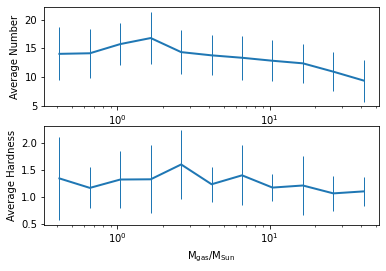

In [202]:
results = np.array(result[:-1])
results = results[results[:,0].argsort()]

plt.subplot(211)
plt.errorbar(results[:,0]*SMBH0.mass.number*1e-3, results[:,3], results[:,4], elinewidth=1, linewidth=2)
plt.xscale("log")
plt.xlabel(r'M$_\mathrm{gas}$/M$_\mathrm{Sun}$',fontsize=10)
plt.ylabel('Average Number',fontsize=10)

plt.subplot(212)
plt.errorbar(results[:,0]*SMBH0.mass.number*1e-3, results[:,5], results[:,6], elinewidth=1, linewidth=2)
plt.xscale("log")
plt.xlabel(r'M$_\mathrm{gas}$/M$_\mathrm{Sun}$',fontsize=10)
plt.ylabel('Average Hardness',fontsize=10)
plt.savefig("figure_disk/different_mdisk.png", dpi=200, bbox_inches='tight')
plt.show()

np.savetxt("different_disk_results.txt", results, fmt='%s', delimiter=',')

import os
with open('different_disk_results.txt', 'r+') as f:
 content = f.read()  
 f.seek(0, 0)
 f.write('#M_disk/M_SMBH,rho/g.cm^-3,N_disk,mean_N,delta_N,mean_hardness,delta_hardness\n'+content)